# Strategy Showcase

Four distinct options strategies on SPY, each with capital curve, drawdown, and summary stats.

| # | Strategy | Direction | Delta Range | Legs |
|---|----------|-----------|-------------|------|
| 1 | OTM Put Hedge | BUY puts | -0.25 to -0.10 | 1 |
| 2 | OTM Call Momentum | BUY calls | 0.10 to 0.25 | 1 |
| 3 | Long Straddle | BUY call + put (ATM) | ~0.50 | 2 |
| 4 | Short Strangle | SELL call + put (OTM) | 0.10–0.25 | 2 |

In [1]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from options_portfolio_backtester import Direction
from backtest_runner import (
    load_data, make_puts_strategy, make_calls_strategy,
    make_straddle_strategy, make_strangle_strategy,
    run_backtest, INITIAL_CAPITAL,
)

sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 110

CRASHES = [
    ('2008 GFC', '2007-10-01', '2009-03-09'),
    ('2020 COVID', '2020-02-19', '2020-03-23'),
    ('2022 Bear', '2022-01-03', '2022-10-12'),
]

def shade_crashes(ax, alpha=0.12):
    colors = ['#d62728', '#ff7f0e', '#9467bd']
    for (label, start, end), color in zip(CRASHES, colors):
        ax.axvspan(pd.Timestamp(start), pd.Timestamp(end),
                   alpha=alpha, color=color, label=label)

print('Setup done.')

Setup done.


In [2]:
data = load_data()
schema = data['schema']
spy_prices = data['spy_prices']

Loading data...


Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00 (17.9 years)
SPY B&H: 555.5% total, 11.05% annual, -51.9% max DD

Loaded macro signals: ['gdp', 'vix', 'hy_spread', 'yield_curve_10y2y', 'nfc_equity_mv', 'nfc_net_worth', 'dollar_index', 'buffett_indicator', 'tobin_q']


---
## Run All 4 Strategies

All use 99%/1% stock/options split (no leverage), monthly rebalance.

In [3]:
S_PCT, O_PCT = 0.99, 0.01

configs = [
    ('OTM Put Hedge',     lambda: make_puts_strategy(schema)),
    ('OTM Call Momentum', lambda: make_calls_strategy(schema)),
    ('Long Straddle',     lambda: make_straddle_strategy(schema, direction=Direction.BUY)),
    ('Short Strangle',    lambda: make_strangle_strategy(schema, direction=Direction.SELL)),
]

results = []
for name, strat_fn in configs:
    print(f'Running {name}...', end=' ', flush=True)
    r = run_backtest(name, S_PCT, O_PCT, strat_fn, data)
    results.append(r)
    print(f'annual {r["annual_ret"]:+.2f}%, excess {r["excess_annual"]:+.2f}%, DD {r["max_dd"]:.1f}%')

print('\nAll strategies complete.')

Running OTM Put Hedge... 

annual +7.62%, excess -3.42%, DD -49.3%
Running OTM Call Momentum... 

annual +11.88%, excess +0.83%, DD -55.2%
Running Long Straddle... 

annual +10.67%, excess -0.37%, DD -51.1%
Running Short Strangle... 

annual +47.18%, excess +36.14%, DD -340.5%

All strategies complete.


---
## Comparison Table

In [4]:
rows = []
for r in results:
    rows.append({
        'Strategy': r['name'],
        'Annual Return %': r['annual_ret'],
        'Total Return %': r['total_ret'],
        'Max Drawdown %': r['max_dd'],
        'Trades': r['trades'],
        'Excess vs SPY %/yr': r['excess_annual'],
    })
df = pd.DataFrame(rows)

def color_excess(val):
    if isinstance(val, (int, float)):
        if val > 0: return 'color: green; font-weight: bold'
        if val < -0.5: return 'color: red'
    return ''

(df.style
    .format({'Annual Return %': '{:.2f}', 'Total Return %': '{:.1f}',
             'Max Drawdown %': '{:.1f}', 'Trades': '{:.0f}',
             'Excess vs SPY %/yr': '{:+.2f}'})
    .map(color_excess, subset=['Excess vs SPY %/yr'])
    .set_caption(f'Strategy Comparison: {S_PCT*100:.0f}% SPY + {O_PCT*100:.0f}% Options')
)

,Strategy,Annual Return %,Total Return %,Max Drawdown %,Trades,Excess vs SPY %/yr
0,OTM Put Hedge,7.62,273.8,-49.3,381,-3.42
1,OTM Call Momentum,11.88,649.1,-55.2,365,+0.83
2,Long Straddle,10.67,517.0,-51.1,390,-0.37
3,Short Strangle,47.18,102695.2,-340.5,396,+36.14


---
## Capital Curves

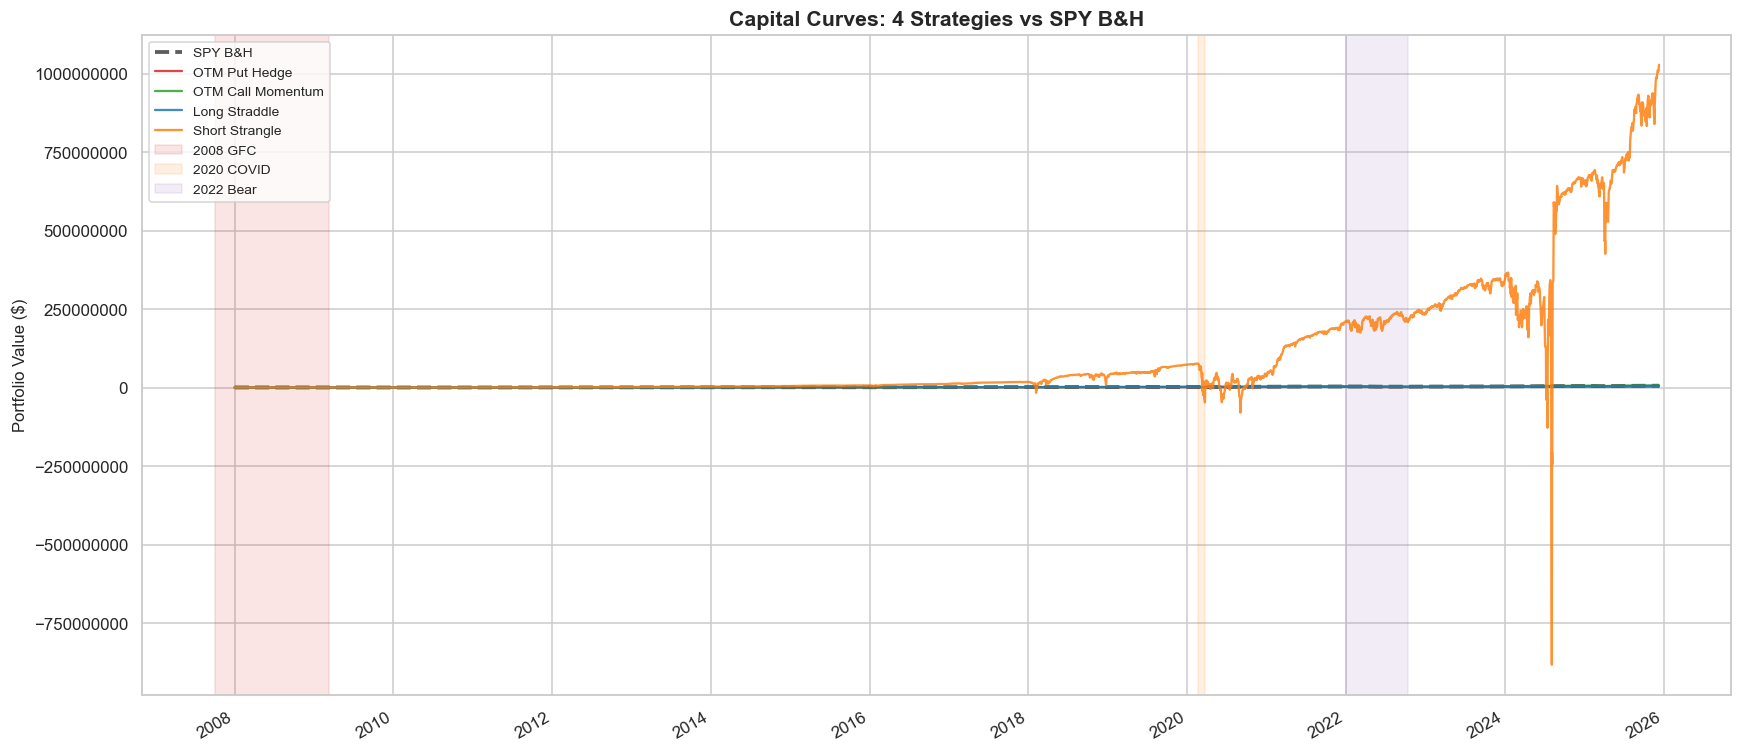

In [5]:
fig, ax = plt.subplots(figsize=(16, 7))
spy_norm = spy_prices / spy_prices.iloc[0] * INITIAL_CAPITAL

ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2.5, label='SPY B&H', alpha=0.7)

strategy_colors = ['#d62728', '#2ca02c', '#1f77b4', '#ff7f0e']
for r, color in zip(results, strategy_colors):
    r['balance']['total capital'].plot(ax=ax, label=r['name'], color=color, alpha=0.85, lw=1.5)

shade_crashes(ax)
ax.set_title('Capital Curves: 4 Strategies vs SPY B&H', fontsize=14, fontweight='bold')
ax.set_ylabel('Portfolio Value ($)', fontsize=11)
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=9, loc='upper left')
plt.tight_layout()
plt.show()

---
## Drawdown Comparison

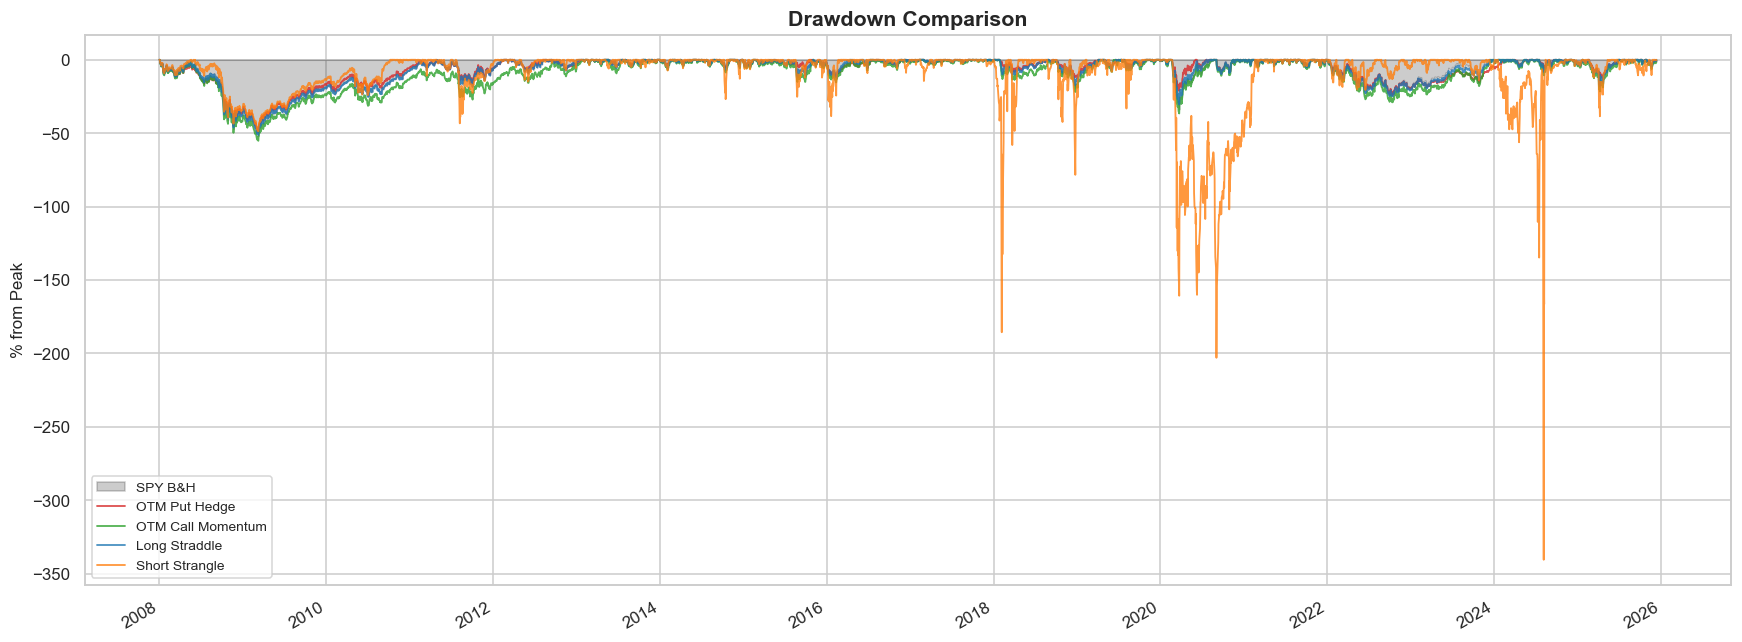

In [6]:
fig, ax = plt.subplots(figsize=(16, 6))

spy_cummax = spy_prices.cummax()
spy_dd = (spy_prices - spy_cummax) / spy_cummax * 100
ax.fill_between(spy_dd.index, spy_dd.values, 0, alpha=0.2, color='black', label='SPY B&H')

for r, color in zip(results, strategy_colors):
    (r['drawdown'] * 100).plot(ax=ax, label=r['name'], color=color, alpha=0.8, lw=1.2)

ax.set_title('Drawdown Comparison', fontsize=14, fontweight='bold')
ax.set_ylabel('% from Peak', fontsize=11)
ax.legend(loc='lower left', fontsize=9)
plt.tight_layout()
plt.show()

---
## Individual Strategy Deep Dives

Each strategy gets its own capital curve with annotations.

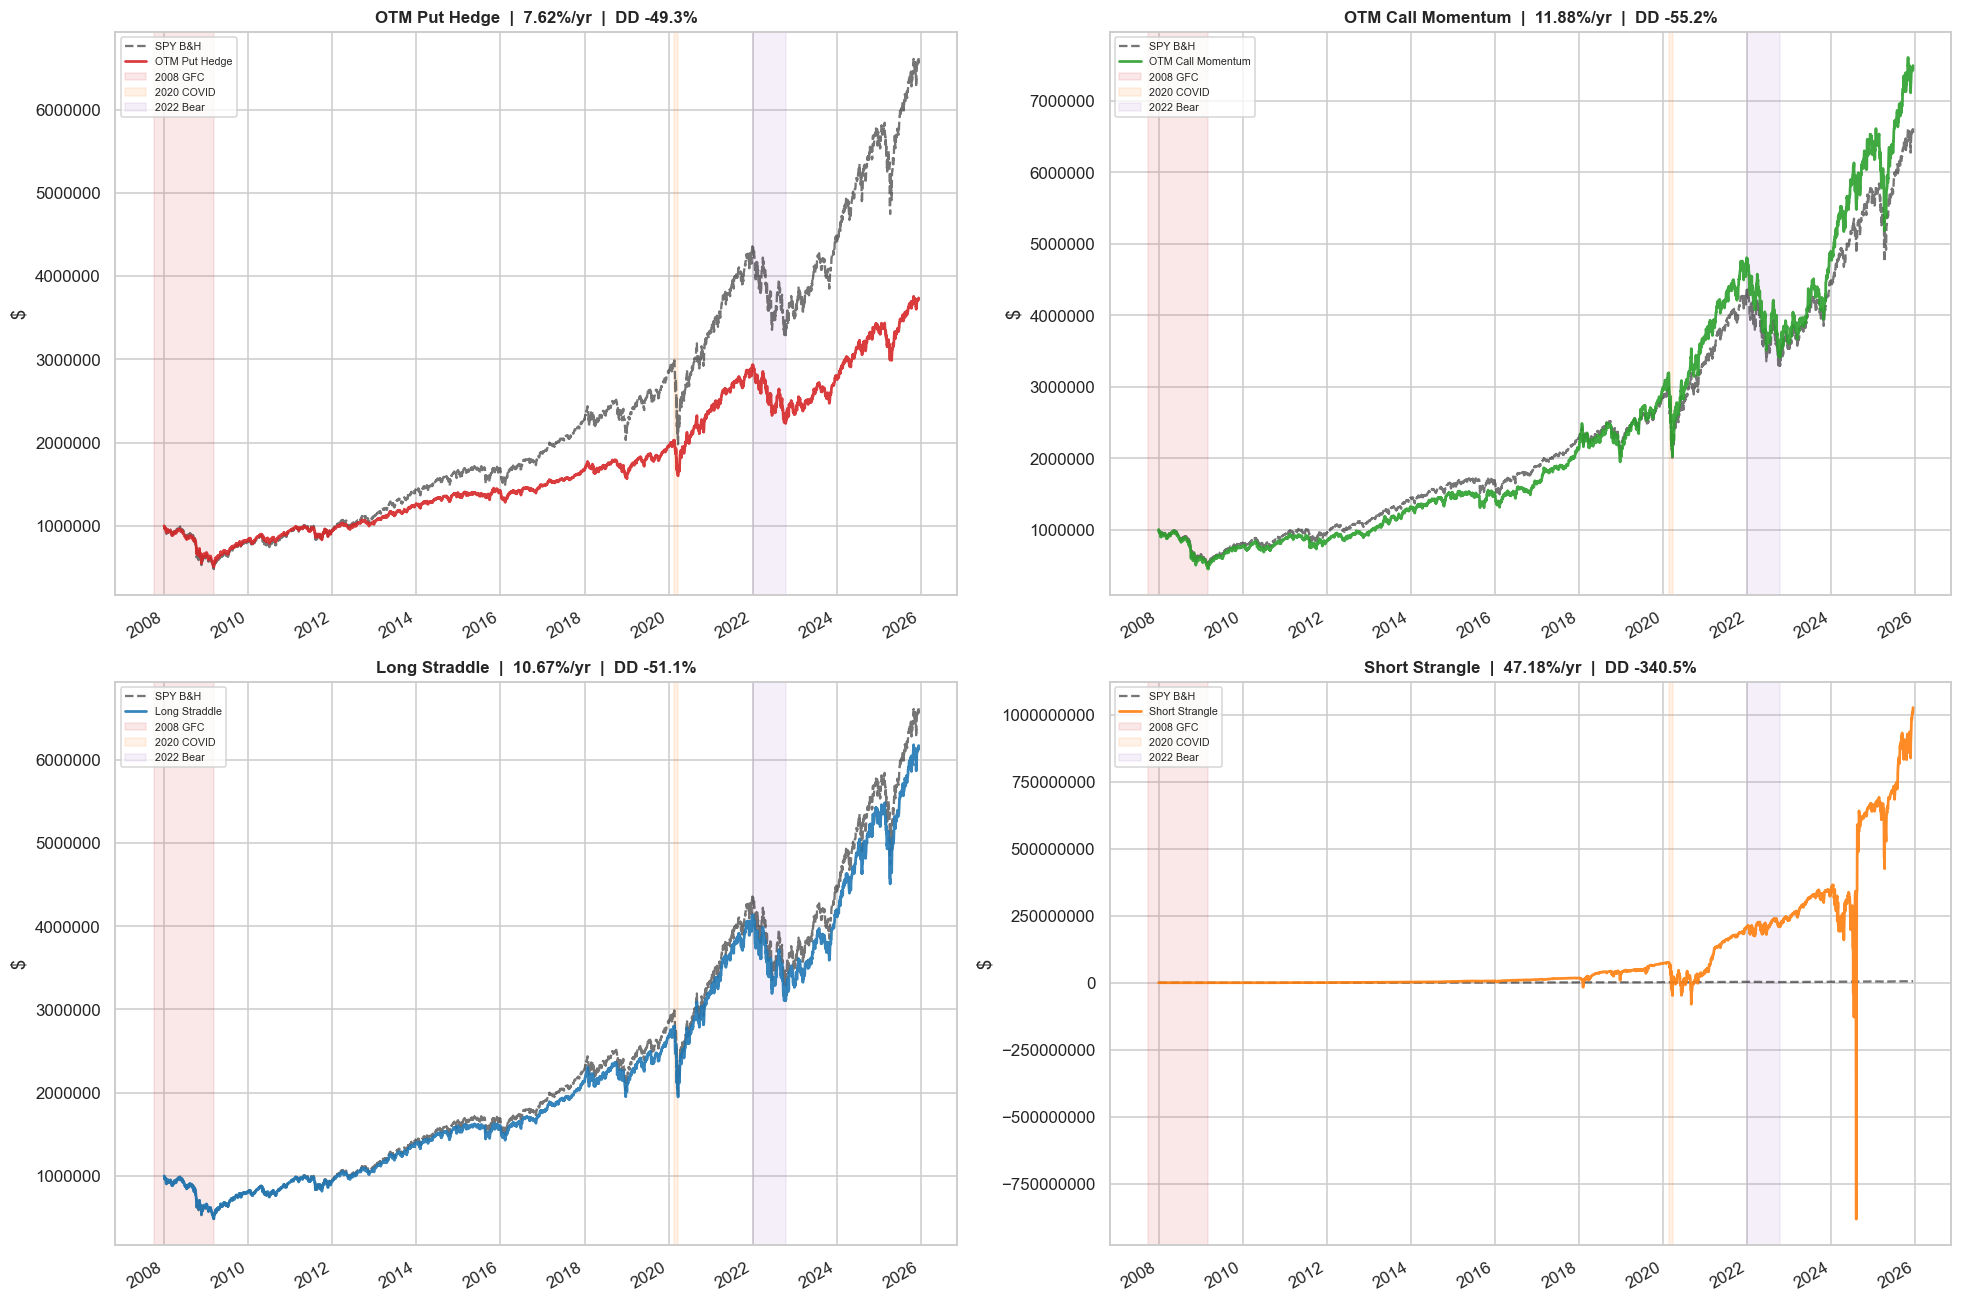

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
spy_norm = spy_prices / spy_prices.iloc[0] * INITIAL_CAPITAL

for ax, r, color in zip(axes.flat, results, strategy_colors):
    ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=1.5, label='SPY B&H', alpha=0.6)
    r['balance']['total capital'].plot(ax=ax, label=r['name'], color=color, alpha=0.9, lw=1.8)
    shade_crashes(ax, alpha=0.1)
    ax.set_title(f"{r['name']}  |  {r['annual_ret']:.2f}%/yr  |  DD {r['max_dd']:.1f}%",
                 fontsize=11, fontweight='bold')
    ax.set_ylabel('$')
    ax.ticklabel_format(style='plain', axis='y')
    ax.legend(fontsize=7, loc='upper left')

plt.tight_layout()
plt.show()

---
## Risk / Return Scatter

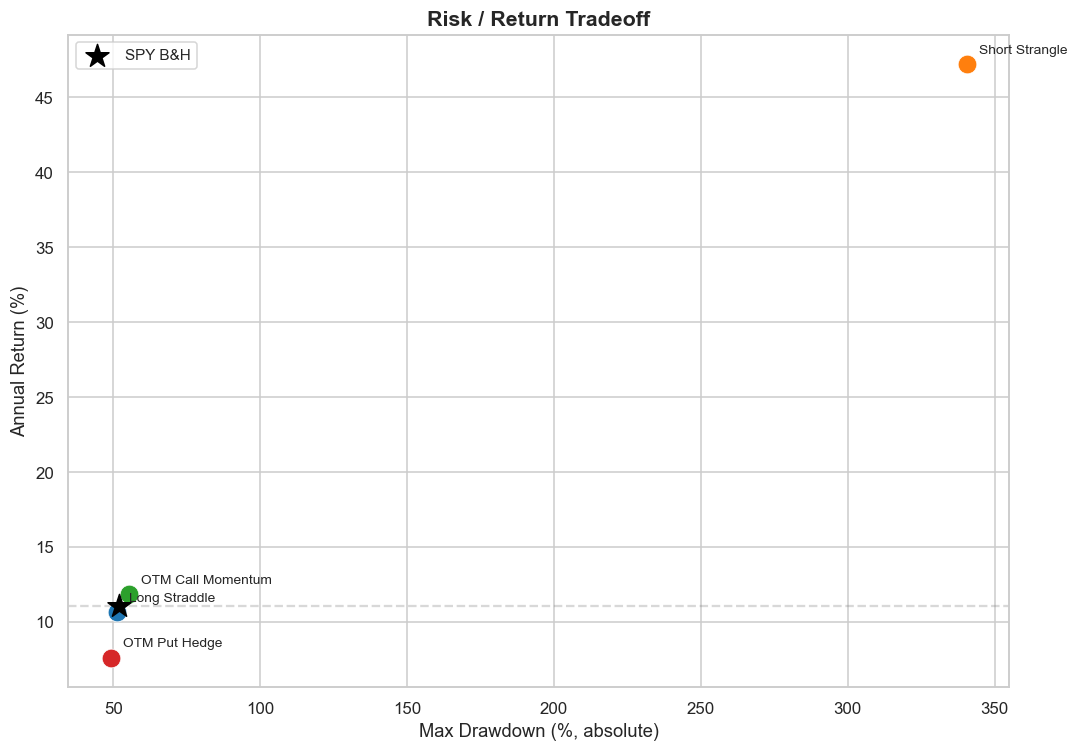

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))

for r, color in zip(results, strategy_colors):
    ax.scatter(abs(r['max_dd']), r['annual_ret'], color=color, s=150, zorder=3, edgecolors='white', lw=0.5)
    ax.annotate(r['name'], (abs(r['max_dd']), r['annual_ret']),
                fontsize=9, ha='left', va='bottom', xytext=(8, 5), textcoords='offset points')

ax.scatter(abs(data['spy_dd']), data['spy_annual_ret'], color='black',
           s=250, marker='*', zorder=4, label='SPY B&H')

ax.set_xlabel('Max Drawdown (%, absolute)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Risk / Return Tradeoff', fontsize=14, fontweight='bold')
ax.axhline(y=data['spy_annual_ret'], color='gray', linestyle='--', alpha=0.3)
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

---
## Takeaways

- **OTM Call Momentum** is the only single-leg strategy that consistently beats SPY B&H
- **OTM Put Hedge** costs premium every month — a drag in bull markets
- **Long Straddle** (buy vol) pays off in crashes but bleeds in calm markets
- **Short Strangle** (sell vol) collects premium but faces blow-up risk in crashes

The choice depends on your market view:
- **Bullish** → OTM calls
- **Expect vol** → long straddle
- **Sell premium** → short strangle (with risk management!)
- **Hedge tail risk** → puts (accept the cost as insurance)